# 正则化---从 0 开始 
本章 从 0 开始介绍如何的正则化来应对 过拟合 问题 

# 高维线性回归 
我们使用高维线性回归为例来引入一个过拟合问题
具体来说我们使用如下的线性函数来生成每一个数据样本 。 
       
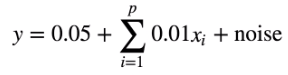

这里噪音服从均值0和标准差为0.01的正态分布。
需要注意的是，我们用以上相同的数据生成函数来生成训练数据集和测试数据集。
为了观察拟合，我们特意把训练数据样本数设低，例如n=20,同时把维度升高，例如 p=200. 


In [1]:
from mxnet import ndarray as nd 
from mxnet import autograd 
from mxnet import gluon 

num_train=20 
num_test=100
num_inputs=200 


# 生成数据集 
这里定义模型真是参数 

In [2]:
true_w=nd.ones((num_inputs,1))*0.01 
true_b =0.05 

接着我们生成训练和测试数据集 。 

In [3]:
X=nd.random.normal(shape=(num_train+num_test,num_inputs))
y=nd.dot(X,true_w)
y+=0.01*nd.random.normal(shape=y.shape) 
X_train,X_test =X[:num_train,:],X[num_train:,:] 
y_train,y_test=y[:num_train],y[num_train:]

当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数，它每次返回batch_size个随机的样本和对应的目标，我们通过python的yield 来构造一个迭代器 

In [4]:
import random 
batch_size=1 
def data_iter(num_examples):
    idx=list(range(num_examples))
    random.shuffle(idx) 
    for i in range(0,num_examples,batch_size):
        j=nd.array(idx[i:min(i+batch_size,num_examples)])
        yield X.take(j),y.take(j)

初始化模型参数。之后训练时，我们需要对这些参数求导来更新他们的值，
所以我们需要提高创建它们的梯度 。 

In [5]:
def get_params():
    w=nd.random.normal(shape=(num_inputs,1))*0.1 
    b=nd.zeros((1,)) 
    for param in (w,b): 
        param.attach_grad()
    return (w,b) 

# L2范数正则化 
线性模型就是将输入和模型做乘法再加上偏移。
这里我们引入L2范数正则化。不同于在训练时仅仅最小化损失函数(Loss),我们在训练时其实在最小化 

直观上，L2范数正则化试图惩罚较大绝对值的参数值。在训练模型时，如果 PAI=0，则未使用正则化。需要注意的是，在测试模型时，PAI必须为0 . 

In [6]:
def net(X,lambd,w,b):
#     return nd.dot(X,w)+b+lambd*((w**2).sum()+b **2)
    return nd.dot(X,w)+b

# 定义训练和测试 
我们定义一个训练函数，这样在跑不同的实验时，不需要重复实现相同的步骤 。 

In [7]:
%matplotlib inline

import matplotlib as mpl 
mpl.rcParams['figure.dpi']=120 
import matplotlib.pyplot as plt 

def square_loss(yhat,y):
    return (yhat-y.reshape(yhat.shape))**2 

def SGD(params,lr):
    for param in params:
        param[:]=param - lr*param.grad

def test(params,X,y):
    return square_loss(net(X,0,*params),y).mean().asscalar() 

In [8]:
def train(lambd):
    epochs=10 
    learning_rate=0.002 
    params=get_params()
    train_loss=[]
    test_loss=[] 
    for e in range(epochs):
        for data,label in data_iter(num_train):
            with autograd.record(): # 计算导数 
                output=net(data,lambd,*params)
                (w,b)=params 
                loss=square_loss(output,label)+lambd*((w**2).sum()+b **2) 
            loss.backward()
            # 更新参数 
            SGD(params,learning_rate) 
        train_loss.append(test(params,X_train,y_train)) 
        test_loss.append(test(params,X_test,y_test)) 
    plt.plot(train_loss) 
    plt.plot(test_loss) 
    plt.legend(['train','test'])
    plt.show() 
    print(len(params))
    return 'learned w[:10]:',params[0][:10],'learned b :',params[1]

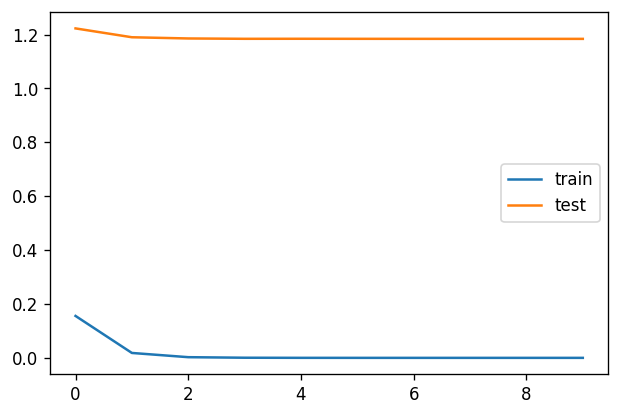

2


('learned w[:10]:',
 
 [[-0.07724071]
  [-0.01743643]
  [-0.07303197]
  [-0.2236414 ]
  [-0.01191538]
  [-0.06824434]
  [-0.00756294]
  [ 0.05817159]
  [-0.10872478]
  [-0.14160833]]
 <NDArray 10x1 @cpu(0)>,
 'learned b :',
 
 [-0.03257207]
 <NDArray 1 @cpu(0)>)

In [9]:
train(0)

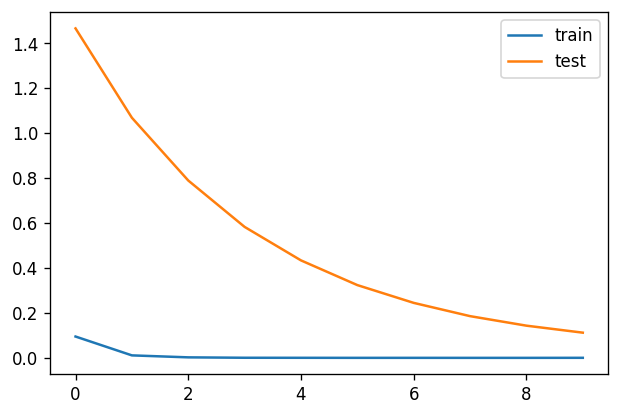

2


('learned w[:10]:',
 
 [[ 0.00866346]
  [ 0.00206233]
  [-0.01104135]
  [ 0.00233899]
  [ 0.00227958]
  [ 0.00685259]
  [ 0.00356402]
  [ 0.00298181]
  [ 0.00741185]
  [ 0.00247809]]
 <NDArray 10x1 @cpu(0)>,
 'learned b :',
 
 [0.00142371]
 <NDArray 1 @cpu(0)>)

In [10]:
train(2)

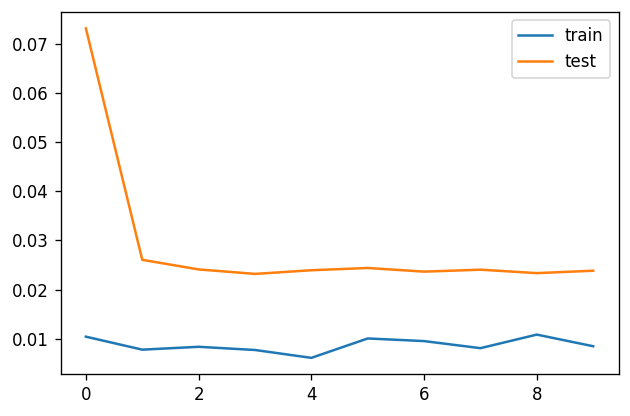

2


('learned w[:10]:',
 
 [[ 2.3790901e-03]
  [ 2.4947328e-03]
  [ 5.2515045e-04]
  [ 4.1733365e-04]
  [-9.8659494e-04]
  [ 1.3834664e-03]
  [ 2.5547546e-04]
  [-4.8339891e-05]
  [ 9.2997286e-04]
  [ 1.9796782e-03]]
 <NDArray 10x1 @cpu(0)>,
 'learned b :',
 
 [0.00250318]
 <NDArray 1 @cpu(0)>)

In [11]:
train(20)